In [ ]:
!unzip data.zip

In [7]:
#@title 2. 필수 라이브러리 임포트
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # (시각화 보강을 위해 추가)

# Scikit-learn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report # (리포트 추가)

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping # (과적합 방지용 추가)

print("Libraries imported.")

Libraries imported.


In [ ]:
#@title 2. 데이터 로드 (사용자님이 명시한 원본 코드 경로 유지)

data_path = '/content/data' # 데이터 폴더 경로

# 원본 코드의 파일 경로 지정 방식 유지
train_data_path = os.path.join(data_path, 'train_motion_data.csv')
test_data_path = os.path.join(data_path, 'test_motion_data.csv')
print('Train data path:', train_data_path)
print('Test data path:', test_data_path)

try:
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)
    print("\nTrain and Test data loaded successfully.")
    print(f"Training DataFrame shape: {train_df.shape}")
    print(f"Test DataFrame shape: {test_df.shape}")

except FileNotFoundError as e:
    print("Please check if the file paths are correct and the files exist in your Google Drive.")
    train_df = None
    test_df = None

if train_df is not None:
    print("\n--- Train Data Head ---")
    print(train_df.head())

Train data path: /content/data/train_motion_data.csv
Test data path: /content/data/test_motion_data.csv

Train and Test data loaded successfully.
Training DataFrame shape: (3644, 8)
Test DataFrame shape: (3084, 8)

--- Train Data Head ---
       AccX      AccY      AccZ     GyroX     GyroY     GyroZ   Class  \
0  0.000000  0.000000  0.000000  0.059407 -0.174707  0.101938  NORMAL   
1 -1.624864 -1.082492 -0.204183 -0.028558  0.051313  0.135536  NORMAL   
2 -0.594660 -0.122410  0.220502 -0.019395 -0.029322  0.087888  NORMAL   
3  0.738478 -0.228456  0.667732  0.069791 -0.029932  0.054902  NORMAL   
4  0.101741  0.777568 -0.066730  0.030696 -0.003665  0.054902  NORMAL   

   Timestamp  
0    3581629  
1    3581630  
2    3581630  
3    3581631  
4    3581631  


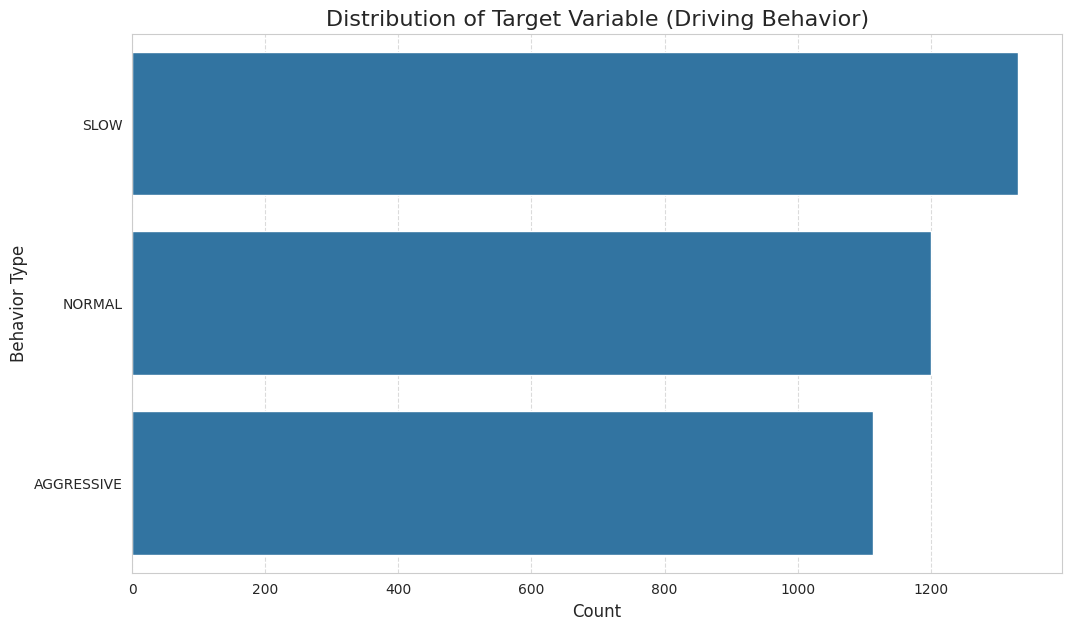

In [ ]:
#@title 3. [EDA 보강] Target(Class) 분포 확인 (영문 Plot)

if train_df is not None:
    target_col = 'Class' if 'Class' in train_df.columns else 'label'

    plt.figure(figsize=(12, 7))
    sns.countplot(data=train_df, y=target_col, order=train_df[target_col].value_counts().index)
    plt.title('Distribution of Target Variable (Driving Behavior)', fontsize=16)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Behavior Type', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

In [13]:
train_df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp
0,0.000000,0.000000,0.000000,0.059407,-0.174707,0.101938,NORMAL,3581629
1,-1.624864,-1.082492,-0.204183,-0.028558,0.051313,0.135536,NORMAL,3581630
2,-0.594660,-0.122410,0.220502,-0.019395,-0.029322,0.087888,NORMAL,3581630
3,0.738478,-0.228456,0.667732,0.069791,-0.029932,0.054902,NORMAL,3581631
4,0.101741,0.777568,-0.066730,0.030696,-0.003665,0.054902,NORMAL,3581631
...,...,...,...,...,...,...,...,...
3639,0.915688,-2.017489,1.687505,0.450360,0.384845,-1.236468,SLOW,3583789
3640,-1.934203,0.914925,-0.096013,0.321468,0.649350,-0.477162,SLOW,3583790
3641,-0.222845,0.747304,-0.887430,0.361174,-0.406836,0.054291,SLOW,3583790
3642,-0.349423,0.067261,0.394368,-0.132405,0.020159,-0.004963,SLOW,3583791


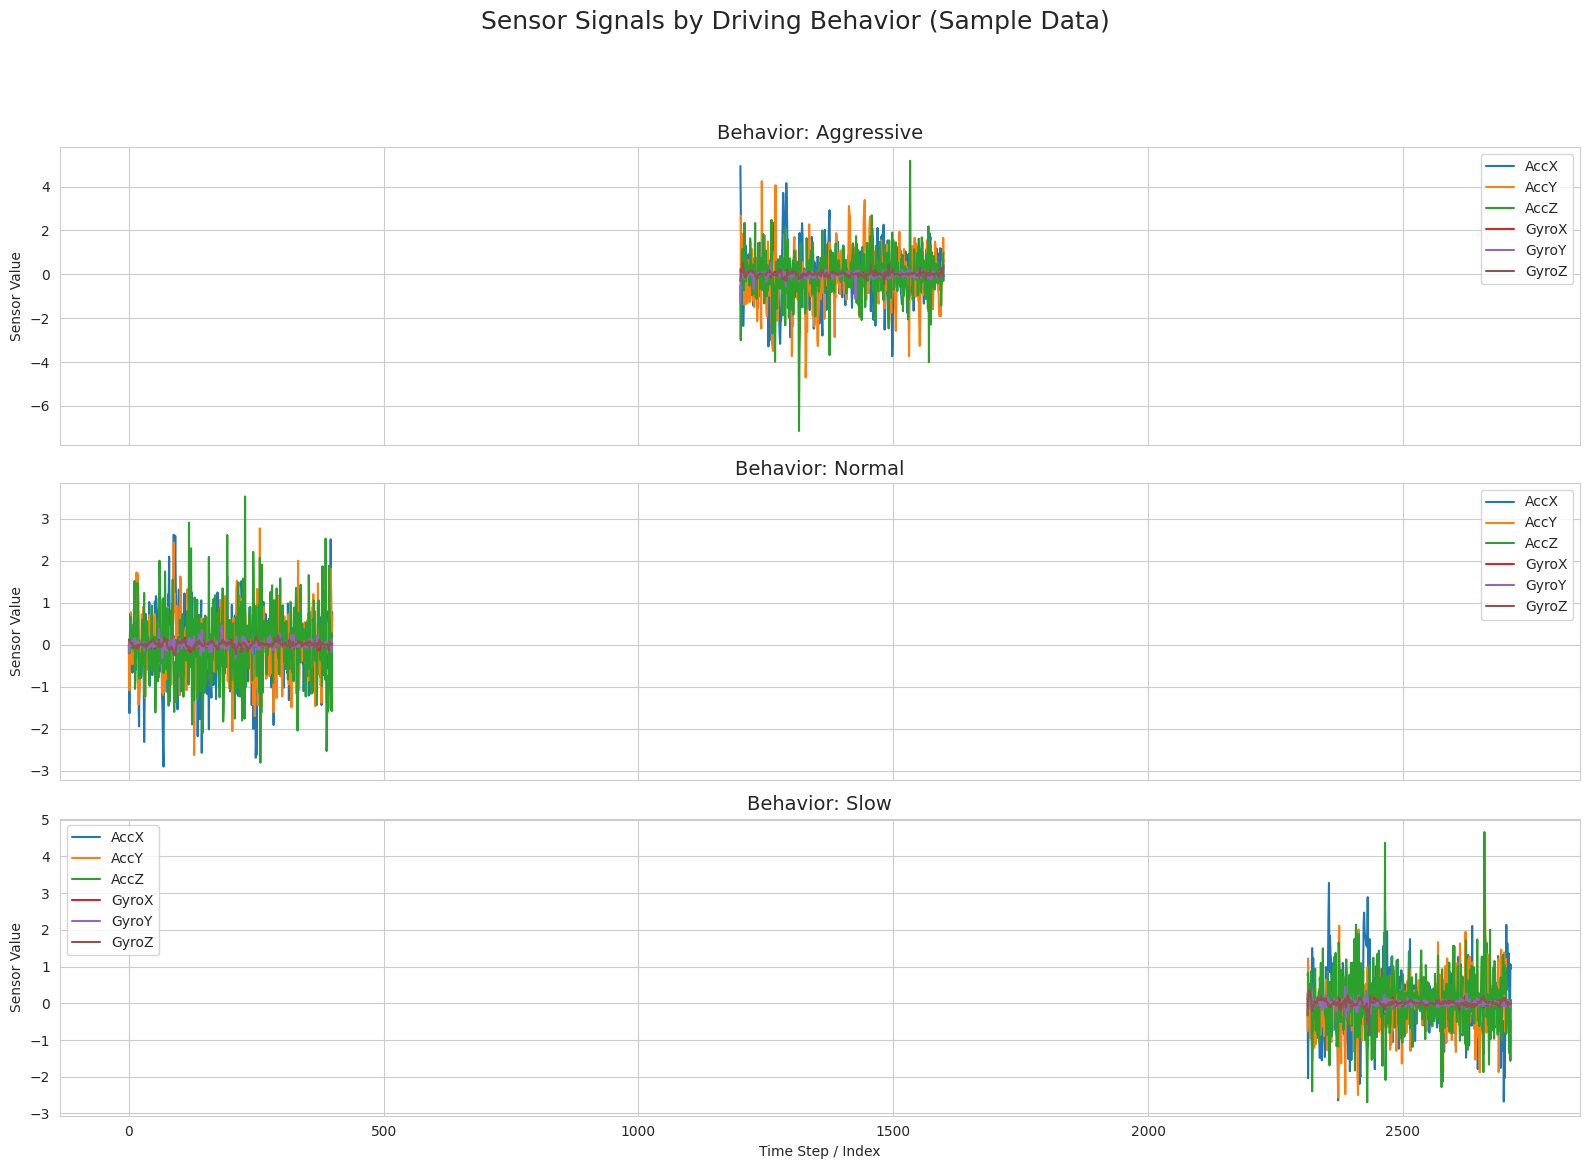

In [ ]:
#@title 4. [EDA 보강] 행동 유형별 센서 신호 시각화 (영문 Plot) [수정됨]

if train_df is not None:
    target_col = 'Class' if 'Class' in train_df.columns else 'label'

    sensor_features = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']
    labels_to_plot = ['AGGRESSIVE', 'NORMAL', 'SLOW']

    existing_labels = [label for label in labels_to_plot if label in train_df[target_col].unique()]

    if not existing_labels:
        print("Warning: None of the specified labels_to_plot were found in the data.")
        print(f"Available labels in your data are: {train_df[target_col].unique()}")
    else:
        fig, axes = plt.subplots(len(existing_labels), 1, figsize=(16, 4 * len(existing_labels)), sharex=True, squeeze=False)
        axes = axes.flatten()

        fig.suptitle('Sensor Signals by Driving Behavior (Sample Data)', fontsize=18, y=1.0)

        for i, label in enumerate(existing_labels):
            sample_data = train_df[train_df[target_col] == label].iloc[:400]

            if not sample_data.empty:
                time_axis = sample_data['time'] if 'time' in sample_data.columns else sample_data.index

                axes[i].plot(time_axis, sample_data[sensor_features])
                axes[i].set_title(f"Behavior: {label.capitalize()}", fontsize=14)
                axes[i].set_ylabel("Sensor Value")
                axes[i].legend(sensor_features)
                axes[i].grid(True)

        plt.xlabel("Time Step / Index")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

In [ ]:
def create_sequences(X, y, time_steps=100):
    """ 시계열 데이터(시퀀스)를 생성하는 함수 """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

if train_df is not None and test_df is not None:
    target_col = 'Class' if 'Class' in train_df.columns else 'label'

    # 1. 피처(X) 및 라벨(y) 선택
    features = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']
    X_train_raw = train_df[features]
    y_train_raw = train_df[target_col]

    X_test_raw = test_df[features]
    y_test_raw = test_df[target_col]

    # 2. 데이터 스케일링 (StandardScaler)
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_raw), columns=features)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_raw), columns=features)

    # 3. 라벨 인코딩 (String -> Integer)
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_raw)
    y_test_encoded = le.transform(y_test_raw)
    N_CLASSES = len(le.classes_)
    class_names_eng = le.classes_
    print(f"Found {N_CLASSES} classes: {class_names_eng}")

    # 4. 시퀀스 데이터 생성
    print("\nGenerating time-series sequences...")
    TIME_STEPS = 100 # 시퀀스 길이
    X_train, y_train = create_sequences(X_train_scaled, pd.Series(y_train_encoded), time_steps=TIME_STEPS)
    X_test, y_test = create_sequences(X_test_scaled, pd.Series(y_test_encoded), time_steps=TIME_STEPS)

    # 5. 라벨 One-Hot Encoding
    y_train_one_hot = to_categorical(y_train, num_classes=N_CLASSES)
    y_test_one_hot = to_categorical(y_test, num_classes=N_CLASSES)

    print(f"\nFinal Train X shape: {X_train.shape}")
    print(f"Final Test X shape: {X_test.shape}")
else:
    print("Skipping preprocessing as DataFrame is not loaded.")

Found 3 classes: ['AGGRESSIVE' 'NORMAL' 'SLOW']

Generating time-series sequences...

Final Train X shape: (3544, 100, 6)
Final Test X shape: (2984, 100, 6)


In [ ]:
if 'X_train' in locals():
    model = Sequential()
    # 입력 형태: (TIME_STEPS, N_FEATURES)
    model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(N_CLASSES, activation='softmax'))

    # 컴파일
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    print("LSTM Model built and compiled.")
    model.summary()

LSTM Model built and compiled.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,019 (336.01 KB)

 Trainable params: 86,019 (336.01 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
#@title 7. 모델 학습 (EarlyStopping 보강)

if 'model' in locals():
    # [보강] 과적합 방지를 위한 EarlyStopping 콜백 추가
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

    print("\nStarting model training...")
    history = model.fit(
        X_train,
        y_train_one_hot,
        epochs=100,
        batch_size=100,
        validation_data=(X_test, y_test_one_hot), # 이미 분리된 test 데이터를 검증용으로 사용
        callbacks=[es],
        verbose=1
    )
    print("\nModel training finished.")
else:
    history = None
    print("Skipping model training as model is not defined.")


Starting model training...
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4341 - loss: 1.0668 - val_accuracy: 0.5013 - val_loss: 0.8554
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5325 - loss: 0.9727 - val_accuracy: 0.6458 - val_loss: 0.8793
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6246 - loss: 0.7458 - val_accuracy: 0.6790 - val_loss: 0.9872
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6822 - loss: 0.5670 - val_accuracy: 0.7058 - val_loss: 0.6877
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7572 - loss: 0.4607 - val_accuracy: 0.7148 - val_loss: 0.8167
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8608 - loss: 0.3285 - val_accuracy: 0.6836 - val_loss: 0.9054
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9337 - loss: 0.1926 - val_accuracy: 0.6830 - val_loss: 1.4000
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9532 - los


Plotting training history...


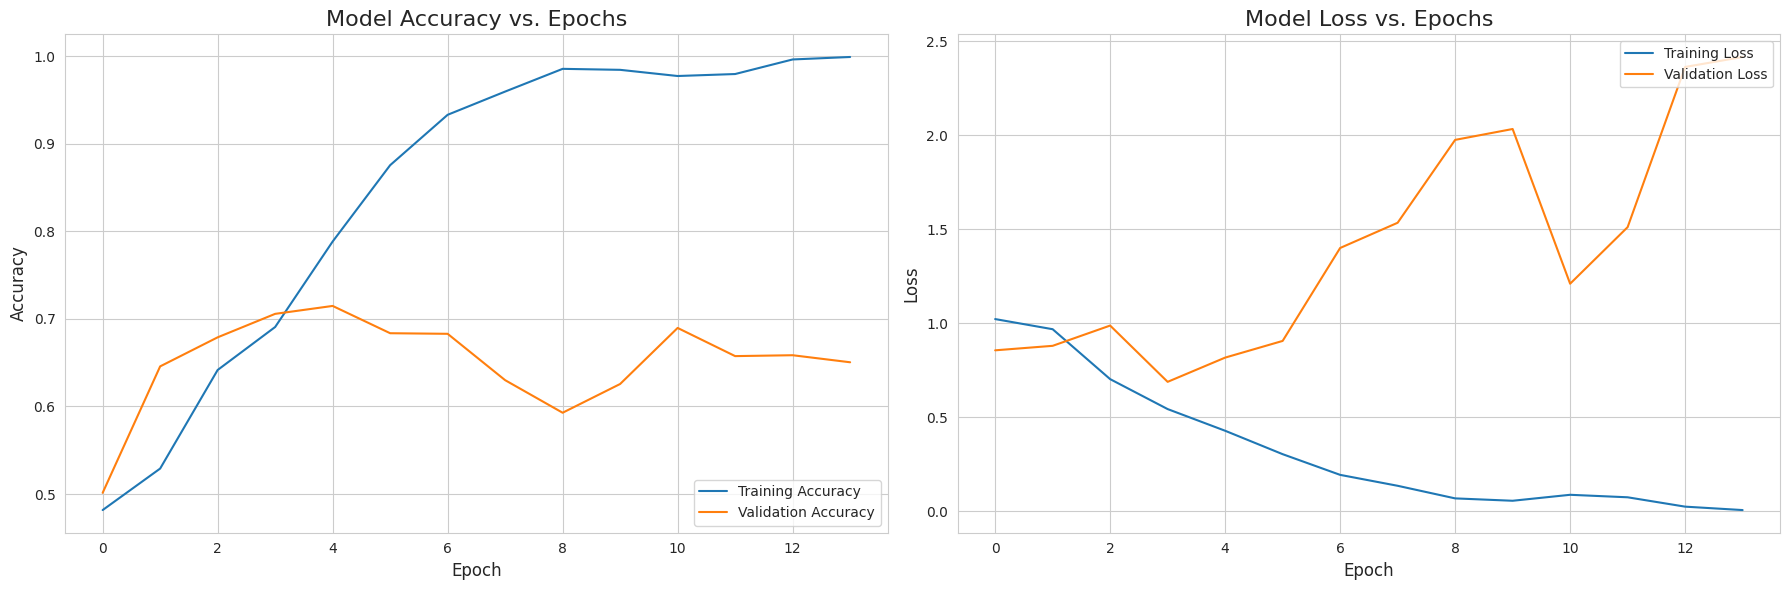

In [20]:
#@title 8. [결과 분석 보강] 학습 곡선 시각화 (Loss & Accuracy - 영문)

if history:
    print("\nPlotting training history...")
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

    # Accuracy Plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy vs. Epochs', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(loc='lower right')
    ax1.grid(True)

    # Loss Plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss vs. Epochs', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.tight_layout()


--- Final Model Evaluation on Test Set ---
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

[Classification Report (English)]
              precision    recall  f1-score   support

  AGGRESSIVE       0.79      0.88      0.83       714
      NORMAL       0.67      0.33      0.44       997
        SLOW       0.68      0.90      0.77      1273

    accuracy                           0.71      2984
   macro avg       0.71      0.70      0.68      2984
weighted avg       0.70      0.71      0.68      2984


Plotting Confusion Matrix...


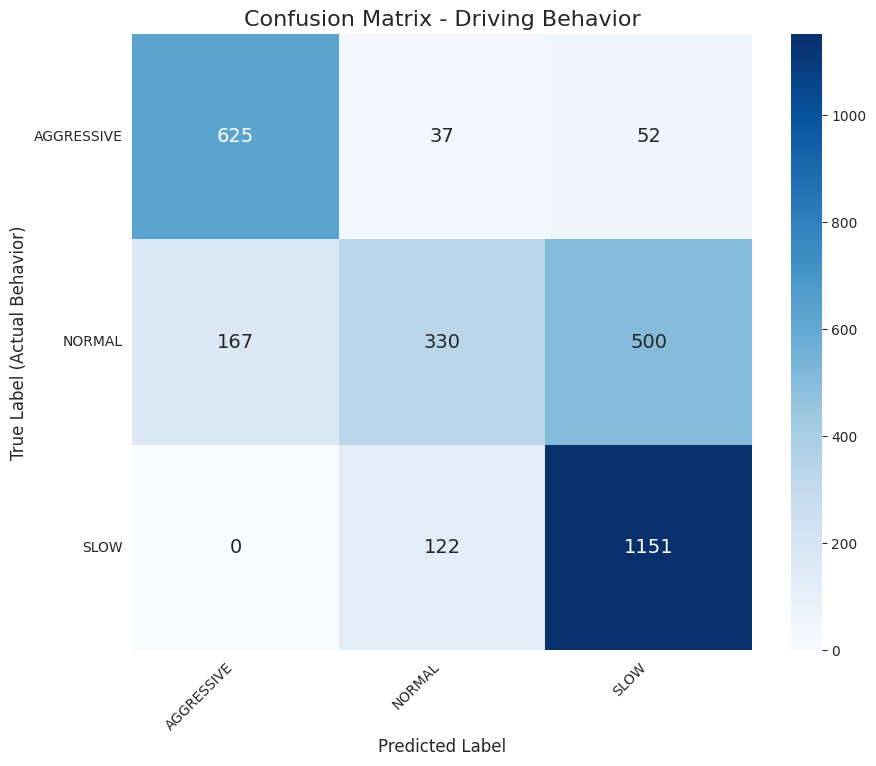

In [21]:
#@title 9. 최종 평가 (분류 리포트 보강 + 혼동 행렬 개선)

if history:
    print("\n--- Final Model Evaluation on Test Set ---")

    # 예측 수행
    y_pred_probs = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    y_true_labels = np.argmax(y_test_one_hot, axis=1)

    # [보강] 분류 리포트 출력
    print("\n[Classification Report (English)]")
    print(classification_report(y_true_labels, y_pred_labels, target_names=class_names_eng, zero_division=0))

    # [개선] 혼동 행렬 시각화 (Seaborn Heatmap 사용)
    print("\nPlotting Confusion Matrix...")
    cm = confusion_matrix(y_true_labels, y_pred_labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names_eng,
                yticklabels=class_names_eng,
                annot_kws={"size": 14})
    plt.title('Confusion Matrix - Driving Behavior', fontsize=16)
    plt.ylabel('True Label (Actual Behavior)', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()